## Implementing Neural Style Transfer using TensorFlow 2.0

In this tutorial, learn about what powers applications like Prisma and implement it using TensorFlow 2.0.

Convolutional neural networks are the most powerful breed of neural networks for image classification and analysis. Their applications have surpassed many limits and have been proven to be the key element of many deep learning enabled applications we see today. At a very high level, CNNs can learn the internal feature level representations of images that are fed to them which make them so powerful. It turns out that this salient feature of CNNs is not only useful for tasks like image classification but also for image construction. Applications like **Deep Dream** and **Neural Style Transfer** compose images based on layer activations within CNNs and their extracted features. 

In this tutorial, you will be studying how Neural Style Transfer works and how it can be implemented using `TensorFlow` 2.0. Following is the outline of the article - 
- What is neural style transfer?
- Isolation between content and style
- Content features and the content loss
- The style loss and the gram matrix
- Combining both the losses to create a custom loss function 
- Neural style transfer in action

**Note** that in order to follow along with this tutorial, you need to know how CNNs work. If you are looking for resources to have a quick refresher on CNNs, give the following ones a try - 

- DataCamp's [Convolutional Neural Networks for Image Processing](https://www.datacamp.com/courses/convolutional-neural-networks-for-image-processing?tap_a=5644-dce66f&tap_s=357540-5b28dd) course
- [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/)

## What is neural style transfer?

For new entrants in the computer vision and deep learning field, the term _neural style transfer_ can be a bit overwhelming. To understand each and every component of the term, consider the following two images - 

![](https://i.ibb.co/3d1bVBp/download.png)

In the context of neural style transfer, the left image is referred to as the _content_ image and the image on the right side is referred to as the _style_ image. You are interested in stylizing one image (the left one in this case) using another image (right one). This is what constructs the last two words in the term - _style transfer_. To carry out the process  a neural network (CNN) is trained to optimize a custom loss function, hence the first word - _neural_. When the above two images are fused using neural style transfer the final output looks like so (right one) - 

![](https://i.ibb.co/7Cx09dV/download-1.png)

You may ask what is use of neural style transfer? Image if you have an image of a drawing originally made by Vincent van Gogh. You want to see how this drawing would have translated to one of your own drawings. This is one of the applications where neural style transfer finds its use. Another example is several photo filter applications like **Prisma** which lets you perform neural style transfer using a smooth user interface.

## Isolation between content and style

So far the idea that you might have got about neural style transfer is that the process is all about combining the content of one image with the style of another. In fact this is 100% true. In this section, let's understand what are actually meant by content and style in the context of CNNs. 

A CNN is often a collection of several convolutional layers and pooling layers. Convolutional layers are responsible for extracting highly complex features from a given image while the pooling layers discard detailed spatial information that are not relevant for a image classification problem. The effect of this is it helps the CNN to learn the content of a given image rather than anything specific such as color, texture and so on. As we go deeper into a CNN, the complexity of the features increases and the deeper convolutional layers are often referred to as content representations.

An example of style would be anything that is specific to image properties like texture, color and so on - like a prominent use of a certain color within a drawing. Now, the question is how do you extract style of an image? This is done by calculating correlations between the convolutional layers. Correlations give us a measure of how similar/related are two or more variables? To understand this, consider a learned convolutional layer which is composed of several feature maps. For each feature map, you can measure how strongly its detected features relate to the other feature maps in the same layer. This gives you an estimate of things like - is a certain color detected in the first feature map similar to a color in another map?, are there any shapes that are common across the feature maps? These traits/similarities define the style of an image. The process of measuring similarity between the contents of several feature maps within a convolutional layer helps  network to learn multi-scale representation of the given image that focuses on spatial features like texture and color. 

One important point to keep in mind is during applying neural style transfer, you need to also ensure that the content of an image is preserved along with desired style of another image. You will see how this is done shortly in a later section in the tutorial. In the next section, you will be learning about how to extract the features from an image (content image) and calculate the content loss. 

## Quantifying the content image and calculating the content loss

The neural style transfer algorithm was first introduced by Gatys et al. in their 2015 paper, [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576). This tutorial, however, takes reference from [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) which is kind of a continuation to the previous paper mentioned. 

According to the paper **Image Style Transfer Using Convolutional Neural Networks**, it employs a VGG-19 CNN architecture for extracting both the content and style features from the content and style images respectively. For getting the content features, the second convolutional layer from the fourth block (of convolutional layers) is used. For convenience, the authors of the paper named it to be `conv4_2`. Once you get the content features, you will have to compare it to a target image to measure the _content loss_. What is a target image? Why calculating content loss is required here? Let's step back a little and focus on these two questions. 

To combine the content and style features into a single image you will need to start with a _target image_ which is either just a blank or the copy of the content image. Now, in order to learn both the content and style features effectively using a CNN, you will need a custom loss function which you will optimize to get a smooth stylistic image constructed from the content and the style images. This custom loss function is essentially an amalgamation of two different losses - 
- content loss which makes sure that the net amount of content is preserved 
- style loss which takes care of the amount of style getting transfered to the target image

Now that you have a sense of the above two questions, let's return to content loss and define it. The content loss is defined as follows - 

$$
\mathcal{L}_{\text {content}}=\frac{1}{2} \sum\left(T_{c}-C_{c}\right)^{2}
$$

where, $T_c$ refers to the target image and $C_c$ refers to the content image. So, what this loss function is doing is, it is giving you a measure of how far are the features of the content and target images from one another. The network will aim to minimize this loss. In the next section, you will see how the style loss is to be determined. 

## The style loss and the gram matrix

For determining the style loss, the paper instructs to take the representations (numbers essentially) from the following layers and obtain the gram matrices of the feature maps within these layers. 

```
'conv1_1'
'conv2_1'
'conv3_1'
'conv4_1'
'conv5_1'
```

The advantage of using numerous layers for defining the style loss is it allows for learning a multi-scale representation of the style contained in an image. The gram matrices helps you determine how similar are the features across the feature maps within a single convolutional layer. This further depicts non-localized information about the image which shapes the style of it. A gram matrix in this context is calculated in the following way.  

Consider the dimension of a convolved image is 8x8x16 which essentially denotes that it has 16 feature maps. You are now interested in finding the similarities between the features across these features maps using a gram matrix. For that, you first flatten the first two dimensions of the convolved image and turn them into a 1D vector. The dimensions if flattened in this case would contain 64 entries in the 1D vector. This is repeated across the feature maps. So, you get a final matrix of the dimension 16x64 (say matrix A). This matrix is then transposed (becomes 64x16) and multiplied with matrix A. A gram matrix in this case would be of 16x16 dimension. A particular value in the gram matrix would denote the similarities between the feature maps. Pictorially this process resembles the following - 

![](https://i.ibb.co/chg6Htp/Untitled-Diagram.png)

In order to calculate the style loss between the target and the style images, you take the mean squared distances between their gram matrices at each of the convolutional layers' blocks. Formally, this can be defined as the following - 

$$
\mathcal{L}_{\text {style}}=a \sum_{i} w_{i}\left(T_{s, i}-S_{s, i}\right)^{2}
$$

where, $T_(s,i)$ is the gram matrix of the target image calculated at block i and $S_(s,i)$ is the gram matrix of the style image calculated at block i. With $w_i$, you can provide custom weights to the different convolution blocks to attain a detailed representation of the style. Finally, $a$ is a constant that accounts for the values in each layer within the blocks. Let's put the two losses together to define the total loss which the network optimizes in the process of neural style transfer. 

## Defining the total loss

The total loss is now just a matter of addition with custom weights - 

$$
totalLoss = \alpha \mathcal{L}_{\text {content}}+\beta \mathcal{L}_{\text {style}}
$$

where, $\alpha$ denotes content weight and $\beta$ denotes style weight. This helps you in maintaining a good balance between the content and the amount of style getting transferred to the target image. The effect of different combination of $\alpha$ and $\beta$ can be seen in the paper and you are encouraged to check that out. You now have all pieces together to implement neural style transfer. Let's get head-on with it in the next section. 

## Neural style transfer in action

For the implementation part, you will be using `TensorFlow 2.0`. It has a lot of extra-ordinary additions and is one of the most comprehensive updates of the library till date. If you are interested in learning about few of these, you can check out [this article](https://www.datacamp.com/community/tutorials/ten-important-updates-tensorflow). 

The latest version of `TensorFlow` (at the time of writing this tutorial) is `2.0.0-beta0`. If you do not have that installed yet, please get it installed first by following the instructions as specified [here](https://tensorflow.org/beta). You will start by importing the necessary packages and the content and the style images. 

In [2]:
# Packages
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7)

%matplotlib inline

print(tf.__version__)


2.0.0-beta0


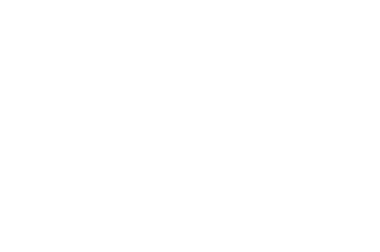

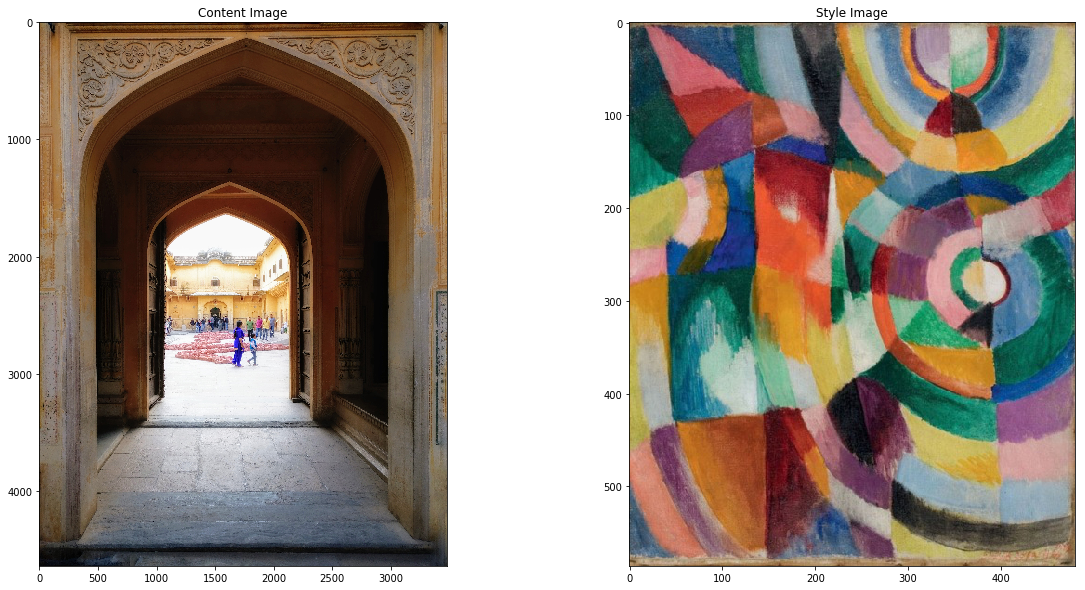

In [5]:
# Load the content and style images
content = plt.imread('Content.jpeg')
style = plt.imread('Style.jpg')

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

In the next step, you will write a helper function which will load the two images in arrays of numbers (becuase computers understand only numbers) and reshape them for making them compatible for the model. 

In [0]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

In [8]:
# Use load_image of content and style images
content = load_image('Content.jpeg')
style = load_image('Style.jpg')

# Verify the shapes
content.shape, style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

The images are reshaped. Now, you will load a pre-trained **VGG19** model for extracting the features. As you will be using the model for extracting features, you will not need the classifier part of the model. 

In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80142336/80134624 [==============================] - 5s 0us/step


The authors have specified the block names they had used for extracting the content and style features. The VGG19 model you just loaded have the same naming convention. So to take that advantage, you will first print the names of all the layers present in the network. 

In [10]:
# Print the layer names for convenience
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


You are interested in the following ones for gettting the style features, however - 
```
'conv1_1'
'conv2_1'
'conv3_1'
'conv4_1'
'conv5_1'
```

For content features, you will need `conv4_2`. You will store these in variables accordingly. 

In [0]:
# Content layer 
content_layers = ['block4_conv2'] 

# Style layer 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)  

You will now create a custom VGG model which will be composed of the specified layers. This will help you to run forward passes on the images and extract the necessary features along the way. 

In [0]:
def mini_model(layer_names, model):
  
  outputs = [model.get_layer(name).output for name in layer_names]

  model = Model([vgg.input], outputs)
  return model

Defining a gram matrix is super easy in TensorFlow and you can do it in the following way - 

In [0]:
# Gram matrix
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram


You will now define custom moodel using the `mini_model()` function. This will be used for returning the content and style features from the respective images. 

In [0]:
class Custom_Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg =  mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # Scale back the pixel values
    inputs = inputs*255.0
    # Preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # Pass through the mini network
    outputs = self.vgg(preprocessed_input)
    # Segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    # Calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # Assign the content representation and gram matrix in 
    # a layer by layer fashion in dicts
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

Now that you have defined the custom model, let's use it on the images to get the content and style features accordingly - 

In [0]:
# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In the paper, optimization was done using the **L-BFGS** algorithm, but you can use Adam also. 

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02)

Let's now define the overall content and style weights and also the weights for each of the style representations as discussed earlier. **Note** that these are hyperparameters and are something you should play with. 

In [0]:
# Custom weights for style and content updates
style_weight=100
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

Now comes the most important part which makes the process of neural style transfer a lot more fun - the loss function. 

In [0]:
# The loss function to optimize
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    # Normalize
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    # Normalize
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

You will now write another function which will:
- calculate the gradients of the loss function you just defined 
- use these gradients to update the target image

With `GradientTape` you can take advantage of automatic differentiation which can calculate the gradients of a function based on its composition. You will also use the `tf.function` decorator to speed up the operations. You can read more about it [here](https://www.tensorflow.org/beta/guide/autograph).

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = total_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

The only step remaining before you can train the network is defining the target image. For the target image, you will use the content image only.  

In [0]:
target_image = tf.Variable(content)

You are now absolutely ready to train the network. 

W0617 16:21:34.491543 140709216896896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


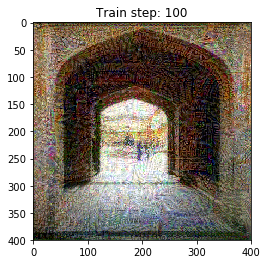

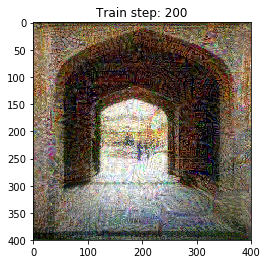

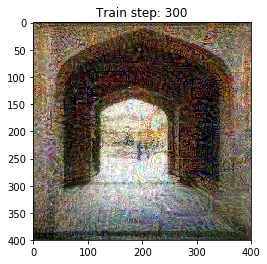

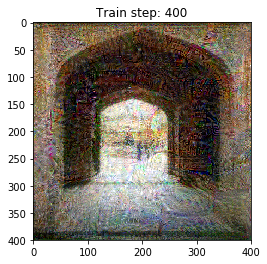

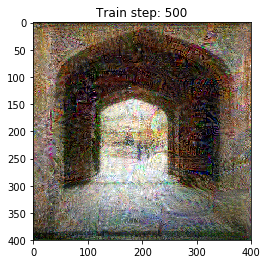

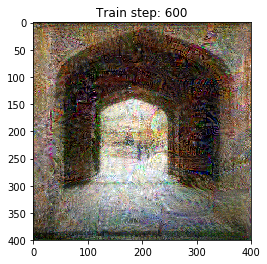

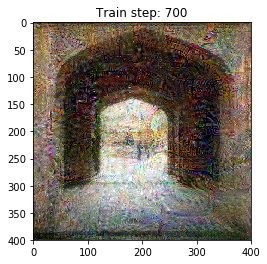

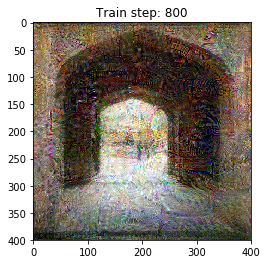

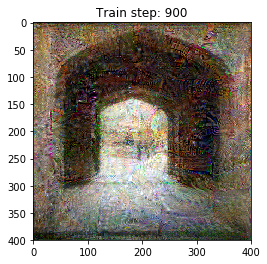

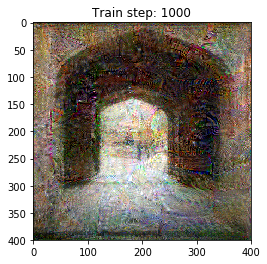

In [21]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()

For better results, you are advised to play with the hyperparameters as mentioned above. 

## Concluding remarks

The paper you referred to here in the tutorial did not mention about further optimizing the quality of the constructed image. As you probably observed in the above results, there are some amout smoothness needed in the spatial relationship between the overall content and style of the constructed image. To combat this problem, **total_variantional_loss** was introduced which is analogous to using regularization. At a high level, **total_variational_loss** penalizes the high frequency artifacts introduced by the original neural style transfer algorithm. You check [this tutorial](https://www.tensorflow.org/beta/tutorials/generative/style_transfer#total_variation_loss), if you are interested in implementing it. Following are some of the resources that were references for writing this tutorial - 
- [Hands-On Transfer Learning with Python](https://www.packtpub.com/in/big-data-and-business-intelligence/hands-transfer-learning-python)
- [Neural style transfer](https://www.tensorflow.org/alpha/tutorials/generative/style_transfer)
- [Lesson on Style Transfer from Udacity](https://classroom.udacity.com/courses/ud188#)
- [Deep Learning for Computer Vision by Adrian Rosebrock (Part II)](https://https://www.pyimagesearch.com/deep-learning-computer-vision-python-book/)

If you are looking to hone your deep learning skills, you might want to check the following DataCamp courses - 
- [Deep Learning in Python](https://www.datacamp.com/courses/deep-learning-in-python?tap_a=5644-dce66f&tap_s=357540-5b28dd)
- [Advanced Deep Learning with Keras in Python](https://www.datacamp.com/courses/advanced-deep-learning-with-keras-in-python?tap_a=5644-dce66f&tap_s=357540-5b28dd)